In [1]:
import holoviews as hv
import numpy as np

HoloViews ordinarily hides the plotting machinery from the user. This allows for very quick iteration over different visualizations to explore a dataset, however it is often important to customize the precise details of a plot. HoloViews makes it very easy to customize existing plots, or even create completely novel plots. This manual will provide a general overview of the plotting system.

The separation of the data from the precise details of the visualization is one of the core principles of the HoloViews. [``Elements``](http://holoviews.org/reference/index.html#elements) provide thin wrappers around chunks of actual data, while [containers](http://holoviews.org/reference/index.html#containers) allow composing these Elements into overlays, layouts, grids and animations/widgets. Each Element or container type has a corresponding plotting class, which renders a visual representation of the data for a particular backend. While the precise details of the implementation differ between backends to accommodate the vastly different APIs  plotting backends provide, many of the high-level details are shared across backends.

# The Store object

The association between an Element or container and the backend specific plotting class is held on the global ``Store`` object. The ``Store`` object holds a ``registry`` of plot objects for each backend. We can view the registry for each backend by accessing ``Store.registry`` directly:

In [2]:
import holoviews.plotting.mpl
list(hv.Store.registry['matplotlib'].items())[0:5]

[(holoviews.element.chart.Curve, holoviews.plotting.mpl.chart.CurvePlot),
 (holoviews.element.chart.Scatter, holoviews.plotting.mpl.chart.PointPlot),
 (holoviews.element.chart.Bars, holoviews.plotting.mpl.chart.BarPlot),
 (holoviews.element.chart.Histogram,
  holoviews.plotting.mpl.chart.HistogramPlot),
 (holoviews.element.chart.Points, holoviews.plotting.mpl.chart.PointPlot)]

The Store object provides a global registry not only for the plots themselves but also creates an entry in the OptionsTree for that particular backend. This allows options for that backend to be validated and enables setting plot, style and normalization options via the [Options](Options.ipynb) system. We can view the ``OptionsTree`` object by requesting it from the store. We'll make a copy with just the first few entries so we can view the structure of the tree:

In [3]:
opts = hv.Store.options(backend='matplotlib')
hv.core.options.OptionTree(opts.items()[0:10], groups=['plot', 'style', 'norm'])

OptionTree(groups=dict_keys(['plot', 'style', 'norm']),
   plot={'Points' : dict(show_frame=True)},

   style={
            'Bars      ' : dict(color=Cycle(values=['#30a2da', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b']), ec='k'),
            'BoxWhisker' : dict(boxprops={'color': 'k', 'linewidth': 1.5}, whiskerprops={'color': 'k', 'linewidth': 1.5}),
            'Curve     ' : dict(color=Cycle(values=['#30a2da', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b']), linewidth=2),
            'ErrorBars ' : dict(ecolor='k'),
            'Histogram ' : dict(ec='k', facecolor=Cycle(values=['#30a2da', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b'])),
            'Points    ' : dict(cmap='fire', color=Cycle(values=['#30a2da', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b']), marker='o'),
            'Scatter   ' : dict(cmap='fire', color=Cycle(values=['#30a2da', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b']), marker='o'),
            'Spikes    ' : dict(cmap='fire', color='black'),
            'Spread    ' :

# Renderers

HoloViews provides a general ``Renderer`` baseclass, which defines a general interface to render the output from different backends to a number of standard output formats such as ``png``, ``html`` or ``svg``. The ``__call__`` method on the Renderer automatically looks up and instantiates the registered plotting classes for an object it is passed and then returns the output in the requested format. To make this a bit clearer we'll break this down step by step. First we'll get a handle on the ``MPLRenderer`` and create an object to render.

Renderers aren't registered with the Store until the corresponding backends have been imported. Loading the notebook extension with ``hv.notebook_extension('matplotlib')`` is one way of loading a backend and registering a renderer. Another is to simply import the corresponding plotting module as we did above.

In [4]:
hv.Store.renderers

OrderedDict([('matplotlib',
              MPLRenderer(backend='matplotlib', css={}, dpi=72, fig='auto', fps=20, holomap='auto', info_fn=<function Exporter.<lambda> at 0x00000217EEF8C8C8>, interactive=False, key_fn=None, mode='default', name='MPLRenderer00081', post_render_hooks={'svg': [], 'png': []}, size=100, widget_mode='embed'))])

This is one way to access a Renderer, another is to instantiate a Renderer instance directly, allowing you to override some of the default plot options.

In [5]:
renderer = hv.plotting.mpl.MPLRenderer.instance(dpi=120)

The recommended way to get a handle on a renderer is to use the ``hv.renderer`` function which will also handle imports for you:

In [6]:
hv.renderer('matplotlib')

MPLRenderer(backend='matplotlib', css={}, dpi=72, fig='auto', fps=20, holomap='auto', info_fn=<function Exporter.<lambda> at 0x00000217EEF8C8C8>, interactive=False, key_fn=None, mode='default', name='MPLRenderer00081', post_render_hooks={'svg': [], 'png': []}, size=100, widget_mode='embed')

# Working with a Renderer

A ``Renderer`` in HoloViews is responsible for instantiating a HoloViews plotting class. It does this by looking up the plotting class in the ``Store.registry``:

In [7]:
hv.Store.registry['matplotlib'][hv.Curve]

holoviews.plotting.mpl.chart.CurvePlot

If we create a ``Curve`` we can instantiate a plotting class from it using the ``Renderer.get_plot`` method:

In [8]:
curve = hv.Curve(range(10))
curve_plot = renderer.get_plot(curve)
curve_plot

CurvePlot(apply_extents=True, apply_ranges=True, apply_ticks=True, aspect='square', autotick=False, bgcolor=None, fig_alpha=1.0, fig_bounds=(0.15, 0.15, 0.85, 0.85), fig_inches=4.0, fig_latex=False, fig_rcparams={}, fig_size=100.0, final_hooks=[], finalize_hooks=[], fontsize=None, initial_hooks=[], interpolation='linear', invert_axes=False, invert_xaxis=False, invert_yaxis=False, invert_zaxis=False, labelled=['x', 'y'], logx=False, logy=False, logz=False, name='CurvePlot01092', normalize=True, projection=None, relative_labels=False, show_frame=False, show_grid=False, show_legend=True, show_title=True, sublabel_format=None, sublabel_position=(-0.35, 0.85), sublabel_size=18, title_format='{label} {group}\n{dimensions}', xaxis='bottom', xrotation=0, xticks=None, yaxis='left', yrotation=0, yticks=None, zaxis=True, zrotation=0, zticks=None)

We will revisit how to work with ``Plot`` instances later. For now all we need to know is that they are responsible for translating the HoloViews object (like the ``Curve``) into a backend specific plotting object, accessible on ``Plot.state``:

Figure(288x288)


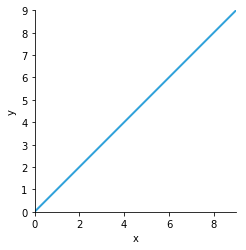

In [9]:
print(curve_plot.state)
curve_plot.state

In case of the matplotlib backend this is a ``Figure`` object. However the ``Renderer`` ignores the specific representation of the plot, instead providing a unified interface to translating it into a representation that can displayed, i.e. either an image format or an HTML representation.

In this way we can convert the curve directly to its ``png`` representation by calling the ``Renderer`` with the object and the format:

{'file-ext': 'png', 'mime_type': 'image/png'}


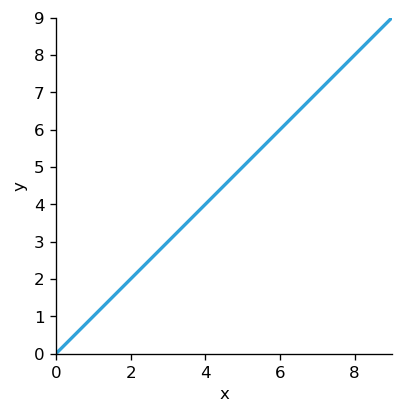

In [10]:
from IPython.display import display_png
png, info = renderer(curve, fmt='png')
print(info)
display_png(png, raw=True)

<div class="alert alert-success">
Tip: To find more information about any HoloViews object use ``hv.help`` to print a detailed docstring.
</div>

The valid figure display formats can be seen in the docstring of the Renderer or directly on the parameter:

In [11]:
renderer.params('fig').objects

['png', 'svg', 'pdf', 'html', None, 'auto']

In this way we can easily render the plot in different formats:

{'file-ext': 'svg', 'mime_type': 'image/svg+xml'}


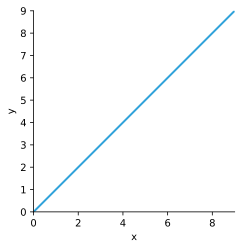

In [12]:
from IPython.display import display_svg
svg, info = renderer(curve, fmt='svg')
print(info)
display_svg(svg, raw=True)

We could save these byte string representations ourselves but the ``Renderer`` provides a convenient ``save`` method to do so. Simply supply the object the filename and the format, which doubles as the file extension:

In [13]:
renderer.save(curve, '/tmp/test', fmt='png')

Another convenient way to render the object is to wrap it in HTML, which we can do with the ``html`` method:


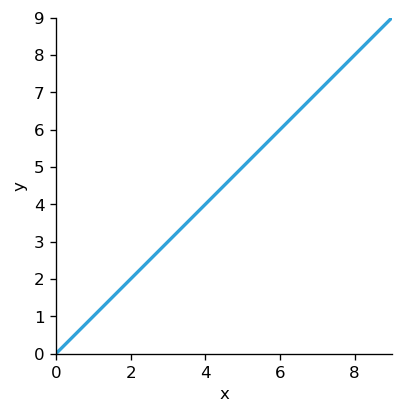

In [14]:
from IPython.display import display_html
html = renderer.html(curve)
display_html(html, raw=True)

Rendering plots containing ``HoloMap`` and ``DynamicMap`` objects will automatically generate a widget class instance, which you can get a handle on with the ``get_widget`` method:

In [15]:
holomap = hv.HoloMap({i: hv.Image(np.random.rand(10, 10)) for i in range(3)})
widget = renderer.get_widget(holomap, 'widgets')
widget

MPLSelectionWidget(CDN={'underscore': 'https://cdnjs.cloudflare.com/ajax/libs/underscore.js/1.8.3/underscore-min.js', 'jQueryUI': 'https://code.jquery.com/ui/1.10.4/jquery-ui.min.js'}, base_template='jsslider.jinja', basejs='widgets.js', css='jsslider.css', display_options={}, embed=True, export_json=False, extensionjs='mplwidgets.js', json_load_path=None, json_save_path='./json_figures', name='MPLSelectionWidget01200', template='jsslider.jinja')

However most of the time it is more convenient to let the Renderer export the widget HTML, again via a convenient method, which will export a HTML document with all the required JS and CSS dependencies:

Default:
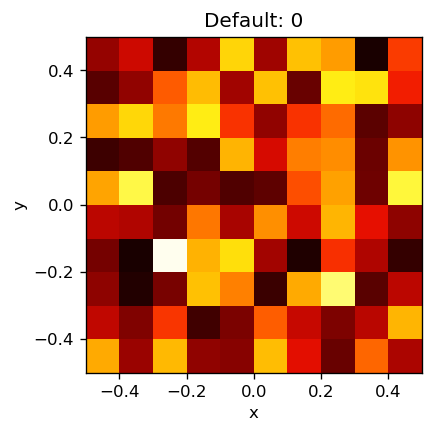
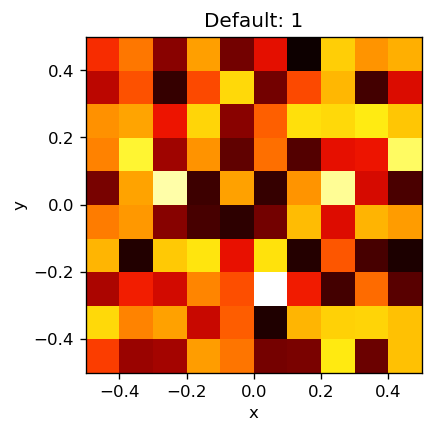
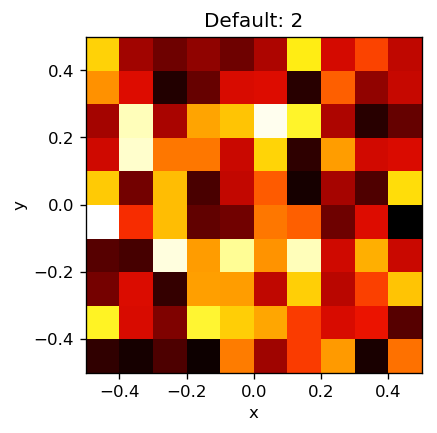

In [16]:
display_html(renderer.static_html(holomap), raw=True)

This covers the basics of working with HoloViews renderers. This API is consistent across plotting backends, whether matplotlib, bokeh or plotly.

# Plots

Above we saw how the Renderer looks up the appropriate plotting class but so far we haven't seen how the plotting actually works. Since HoloViews already nests the data into semantically meaningful components, which define the rough layout of the plots on the page, the plotting classes follow roughly the same hierarchy. To review this hierarchy have a look at the [nesting diagram](./05-Building_Composite_Objects.ipynb#Nesting-hierarchy-) in the Building Composite objects guide.

The Layout and GridSpace plotting classes set up the figure and axes appropriately and then instantiate the subplots for all the objects that are contained within. For this purpose we will create a relatively complex object, a ``Layout`` of ``HoloMap``s containing ``Overlay``s containing ``Elements``. We'll instantiate the matching plotting hierarchy and then inspect it.

In [17]:
hmap1 = hv.HoloMap({i: hv.Image(np.random.rand(10, 10)) * hv.Ellipse(0, 0, 0.2*i) for i in range(5)})
element = hv.Curve((range(10), np.random.rand(10)))
layout = hmap1 + element

We can see the hierarchy in the object's repr:

In [18]:
print( repr(layout) )

:Layout
   .HoloMap.I :HoloMap   [Default]
      :Overlay
         .Image.I   :Image   [x,y]   (z)
         .Ellipse.I :Ellipse   [x,y]
   .Curve.I   :Curve   [x]   (y)


Now that we've created the object we can again use the ``MPLRenderer`` to instantiate the plot:

In [19]:
layout_plot = renderer.get_plot(layout)
layout_plot

LayoutPlot(absolute_scaling=False, aspect_weight=0, fig_alpha=1.0, fig_bounds=(0.05, 0.05, 0.95, 0.95), fig_inches=4.0, fig_latex=False, fig_rcparams={}, fig_size=100.0, final_hooks=[], finalize_hooks=[], fontsize={'title': 16}, hspace=0.5, initial_hooks=[], name='LayoutPlot01297', normalize=True, projection=None, show_frame=False, show_title=True, sublabel_format='{Alpha}', sublabel_position=(-0.35, 0.85), sublabel_size=18, tight=False, tight_padding=3, title_format='{label} {group}\n{dimensions}', transpose=False, vspace=0.3)

During instantiation the LayoutPlot expanded each object and created subplots. We can access them via a row, column based index and thereby view the first plot.

In [20]:
adjoint_plot = layout_plot.subplots[0, 0]
adjoint_plot

AdjointLayoutPlot(fig_alpha=1.0, fig_bounds=(0.15, 0.15, 0.85, 0.85), fig_inches=4.0, fig_latex=False, fig_rcparams={}, fig_size=100.0, final_hooks=[], finalize_hooks=[], fontsize=None, initial_hooks=[], name='AdjointLayoutPlot01537', normalize=True, projection=None, show_frame=False, show_title=True, sublabel_format=None, sublabel_position=(-0.35, 0.85), sublabel_size=18, title_format='{label} {group}\n{dimensions}')

This plotting layer handles plots adjoined to the plot. They are indexed by their position in the AdjointLayout which may include 'top', 'right' and 'main':

In [21]:
overlay_plot = adjoint_plot.subplots['main']
overlay_plot

OverlayPlot(apply_extents=True, apply_ranges=True, apply_ticks=True, aspect='square', batched=False, bgcolor=None, fig_alpha=1.0, fig_bounds=(0.15, 0.15, 0.85, 0.85), fig_inches=4.0, fig_latex=False, fig_rcparams={}, fig_size=100.0, final_hooks=[], finalize_hooks=[], fontsize=None, initial_hooks=[], invert_axes=False, invert_xaxis=False, invert_yaxis=False, invert_zaxis=False, labelled=['x', 'y'], legend_cols=None, legend_limit=25, legend_position='inner', logx=False, logy=False, logz=False, name='OverlayPlot01480', normalize=True, projection=None, show_frame=False, show_grid=False, show_legend=True, show_title=True, style_grouping=2, sublabel_format='{Alpha}', sublabel_position=(-0.35, 0.85), sublabel_size=18, title_format='{label} {group}\n{dimensions}', xaxis='bottom', xrotation=0, xticks=None, yaxis='left', yrotation=0, yticks=None, zaxis=True, zrotation=0, zticks=None)

Now we've drilled all the way down to the OverlayPlot level, we see as expected that this contains two further subplots, one for the ``Image`` and one for ``Text`` Element. 

In [22]:
overlay_plot.subplots.keys()

odict_keys([('Image', 'I'), ('Ellipse', 'I')])

Now you might have noticed that the HoloMap seems to have disappeared from the hierarchy. This is because updating a particular plot is handled by the ``ElementPlots`` itself. With that knowledge we can now have a look at the actual plotting API.

### Traversing plots

When working with such deeply nested plots accessing leafs can be a lot of effort, therefore the plots also provide a ``traverse`` method letting you specify the types of plots you want to access:

In [23]:
layout_plot.traverse(specs=[hv.plotting.mpl.CurvePlot])

[CurvePlot(apply_extents=True, apply_ranges=True, apply_ticks=True, aspect='square', autotick=False, bgcolor=None, fig_alpha=1.0, fig_bounds=(0.15, 0.15, 0.85, 0.85), fig_inches=4.0, fig_latex=False, fig_rcparams={}, fig_size=100.0, final_hooks=[], finalize_hooks=[], fontsize=None, initial_hooks=[], interpolation='linear', invert_axes=False, invert_xaxis=False, invert_yaxis=False, invert_zaxis=False, labelled=['x', 'y'], logx=False, logy=False, logz=False, name='CurvePlot01561', normalize=True, projection=None, relative_labels=False, show_frame=False, show_grid=False, show_legend=True, show_title=True, sublabel_format='{Alpha}', sublabel_position=(-0.35, 0.85), sublabel_size=18, title_format='{label} {group}\n{dimensions}', xaxis='bottom', xrotation=0, xticks=None, yaxis='left', yrotation=0, yticks=None, zaxis=True, zrotation=0, zticks=None)]

# Plotting API

There a few methods shared by all plotting classes, which allow the renderer to easily create, update and render a plot. The three most important methods and attributes are:

* ``Plot.__init__`` - The constructor already handles a lot of the processing in a plot, it sets up all the subplots if there are any, computes ranges across the object to normalize the display, sets the options that were specified and instantiates the figure, axes, model graphs, or canvas objects dependening on the backend.
* ``Plot.initialize_plot`` - This method draws the initial frame to the appopriate figure, axis or canvas, setting up the various artists (matplotlib) or glyphs (bokeh).
* ``Plot.update`` - This method updates an already instantiated plot with the data corresponding to the supplied key. This key should match the key in the HoloMap.

### Initializing

The Renderer and the widgets use these three methods to instantiate and update a plot to render both static frames and animations or widgets as defined by the ``HoloMap`` or ``DynamicMap``. Above we already instantiated a plot, now we initialize it, thereby drawing the first (or rather last frame).

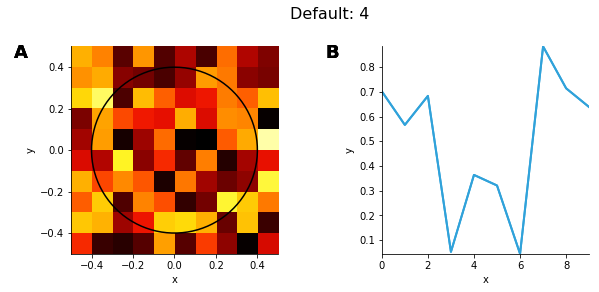

In [24]:
fig = layout_plot.initialize_plot()
fig

### Updating

We can see ``initialize_plot`` has rendered the last frame with the key ``4``. We can update the figure with another key simply by calling the ``Plot.update`` method with the corresponding key.

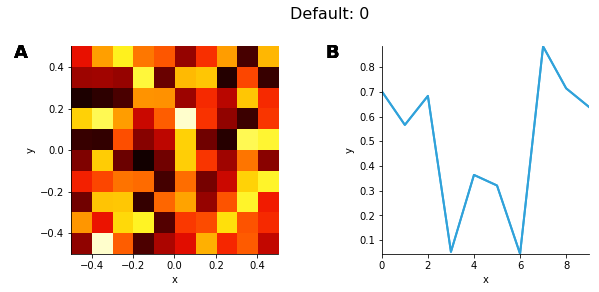

In [25]:
layout_plot.update(0)

In [26]:
plot = hv.plotting.mpl.RasterPlot(holomap)
plot

RasterPlot(apply_extents=True, apply_ranges=True, apply_ticks=True, aspect='equal', bgcolor=None, cbar_padding=0.01, cbar_ticks=None, cbar_width=0.05, clipping_colors={}, colorbar=False, fig_alpha=1.0, fig_bounds=(0.15, 0.15, 0.85, 0.85), fig_inches=4.0, fig_latex=False, fig_rcparams={}, fig_size=100.0, final_hooks=[], finalize_hooks=[], fontsize=None, initial_hooks=[], invert_axes=False, invert_xaxis=False, invert_yaxis=False, invert_zaxis=False, labelled=['x', 'y'], logx=False, logy=False, logz=False, name='RasterPlot01632', normalize=True, projection=None, show_frame=True, show_grid=False, show_legend=False, show_title=True, situate_axes=False, sublabel_format=None, sublabel_position=(-0.35, 0.85), sublabel_size=18, symmetric=False, title_format='{label} {group}\n{dimensions}', xaxis='bottom', xrotation=0, xticks=None, yaxis='left', yrotation=0, yticks=None, zaxis=True, zrotation=0, zticks=None)

Internally each level of the plotting hierarchy updates all the objects below it, all the way down to the ElementPlots, which handle updating the plotting data.

### Dynamic plot updates

Since DynamicMaps may be updated based on stream events they don't work via quite the same API. Each stream automatically captures the plots it is attached to and whenever it receives an event it will update the plot.

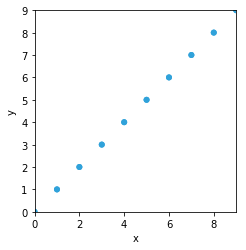

In [27]:
dmap = hv.DynamicMap(lambda x: hv.Points(np.arange(x)), kdims=[], streams=[hv.streams.PointerX(x=10)])
plot = renderer.get_plot(dmap)
plot.initialize_plot()

Internally the update to the stream value will automatically trigger the plot to update, here we will disable this by setting ``trigger=False`` and explicitly calling ``refresh`` on the plot:

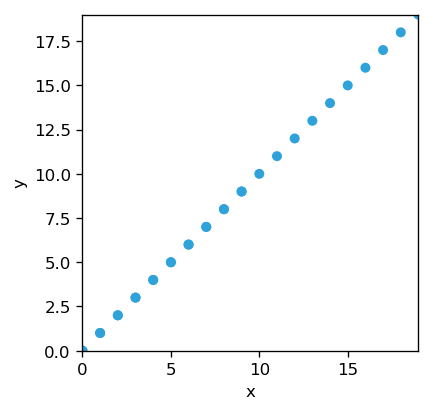

In [28]:
dmap.event(x=20,)
plot.refresh()
plot.state

### Plotting handles

In addition to accessing the overall state of the plot each plotting class usually keeps direct handles for important plotting elements on the ``handles`` attribute:

In [29]:
plot.handles

{'artist': <matplotlib.collections.PathCollection at 0x217f1a96da0>,
 'axis': <matplotlib.axes._subplots.AxesSubplot at 0x217f1a69b38>,
 'bbox_extra_artists': [],
 'fig': <Figure size 480x480 with 1 Axes>,
 'title': Text(0.5,1,'')}

Here we can see how the ``PointPlot`` keeps track of the artist, which is a matplotlib ``PathCollection``, the axis, the figure and the plot title. In addition all matplotlib plots also keep track of a list of any additional plotting elements which should be considered in the bounding box calculation.

This is only the top-level API, which is used by the Renderer to render the plot, animation or widget. Each backend has internal APIs to create and update the various plot components.

### Using the matplotlib renderer outside of a Jupyter notebook

The matplotlib renderer can be used outside of a notebook by using the `show` method. If running in a python script, this will cause the usual matplotlib window to appear. This is done as follows:

    mr = hv.renderer('matplotlib')
    mr.show(curve)